# OpenFoodFacts - Analysis of Packaging Data

__Goal__: Investigate what kind of packaging information is included in the product data and if it is ready to use for display in an app.

<div class="alert alert-block alert-info">
  <b>This notebook focuses on the top 1,000 German products in Open Food Facts that are marked to have complete packaging information.</b>
</div>

__To be analyzed:__
  - the stored packaging information, i.e. packaging containers, coverings, and material.
  - the completeness and consistency of packaging data.
  - statistics about most frequent type of packaging and materials.

__Summary (TL;TR)__
  - only a fraction (~0.9%) of German products are marked as having complete packaging data.
  - those packaging details are still messy. For instance, some products
    - don't have any packaging data.
    - don't have a product name.
    - are missing the "shape" or "material" information in the packaging details.
    - are not properly annotated with the english taxonomy terms for "shape" and "material" but use other languages.
    - have generic "shape" annotations: `en:packaging`, `en:grouping-package`, `en:unknown`.
    - use annotations inconsistently, e.g. frozen pizza with "shape" `en:pizza-box` and `en:bag`|`en:wrapper`|`en:film`.
    - have very specific material annotations, like `xx:80-c-pap`, that are less suitable for display to average customers.
    - have non consolidated annotations, like `en:tetra-brik-aseptic`, `en:tetra-pak`, `en:tetra-brik`.

__-> Given the number of discovered issues the overall data quality is questionable. Even if some products have no obvious data quality issues, it remains unclear if the packaging data is correct and complete.__

In [1]:
import pandas as pd
from urllib.request import urlopen, urlretrieve
from urllib.parse import urlencode
from pathlib import Path
import json

## Download Data from OpenFoodFacts API

___Only fetch the top 1,000 German products with complete packaging information!___

In [2]:
API_URL = "https://de.openfoodfacts.org/api/v2/search?"

PARAMS = {
    "page_size": 1000,
    "misc_tags": "packagings-complete",
    "fields": "code,brands,product_name,packagings,packagings_complete,packaging_tags,unique_scans_n,image_small_url"
}

DATA_FILE = "./off_de_complete_packagings_top1000.json"

# skip download if data has been downloaded before
if not Path(DATA_FILE).exists():
    urlretrieve(API_URL + urlencode(PARAMS), DATA_FILE)

# Exploratory Data Analysis

## Data Preparation

In [3]:
# load json file
with open(DATA_FILE) as f:
    data = json.load(f)

# create data frame from product information
prod_df = (pd.DataFrame(data['products'])
            .drop(['packagings_complete', 'packaging_tags'], axis=1)
            .set_index('code')
          )

computations = {
    # count number of packaging items
    "pack_count": lambda items: len(items),

    # extract packaging shapes
    "pack_shapes": lambda items: [i['shape'] if ('shape' in i) else None for i in items],

    # extract packaging materials
    "pack_materials": lambda items: [i['material'] if ('material' in i) else None for i in items]
}

for key, fn in computations.items():
    prod_df[key] = prod_df.packagings.map(fn)

display(prod_df)

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
3274080005003,Cristaline,https://images.openfoodfacts.org/images/produc...,[{'material': 'en:pet-1-polyethylene-terephtha...,Eau de source,1073,3,"[en:bottle, en:bottle-cap, en:label]","[en:pet-1-polyethylene-terephthalate, en:hdpe-..."
3017620422003,Ferrero,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:clear-glass', 'number_of_uni...",Nutella,923,5,"[en:pot, en:lid, en:backing, en:seal, en:label]","[en:clear-glass, en:pp-5-polypropylene, en:non..."
7622210449283,"Lu,Mondelez",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",Prince Chocolat biscuits au blé complet,842,2,"[en:film, en:sleeve]","[en:plastic, en:cardboard]"
5449000214911,Coca cola,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:aluminium', 'number_of_units...",Coca-cola,685,1,[en:drink-can],[en:aluminium]
3017620425035,Ferrero,https://images.openfoodfacts.org/images/produc...,"[{'material': 'xx:82-c-pap', 'number_of_units'...",Nutella,623,5,"[en:seal, en:lid, en:jar, en:backing, en:label]","[xx:82-c-pap, en:pp-5-polypropylene, en:clear-..."
...,...,...,...,...,...,...,...,...
8690565330289,Pinar,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",Ayran (Joghurtgetränk türkischer Art),2,2,"[en:can, en:lid]","[en:plastic, en:aluminium]"
4021234101109,Barnhouse,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene', 'number...",Krunchy Christmas Haferbasis,2,1,[en:bag],[en:pp-5-polypropylene]
4104420141827,Alnatura,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:paper-and-plastic', 'number_...",Joghurt Butter,2,1,[en:packaging],[en:paper-and-plastic]


## Visualize the top scanned products

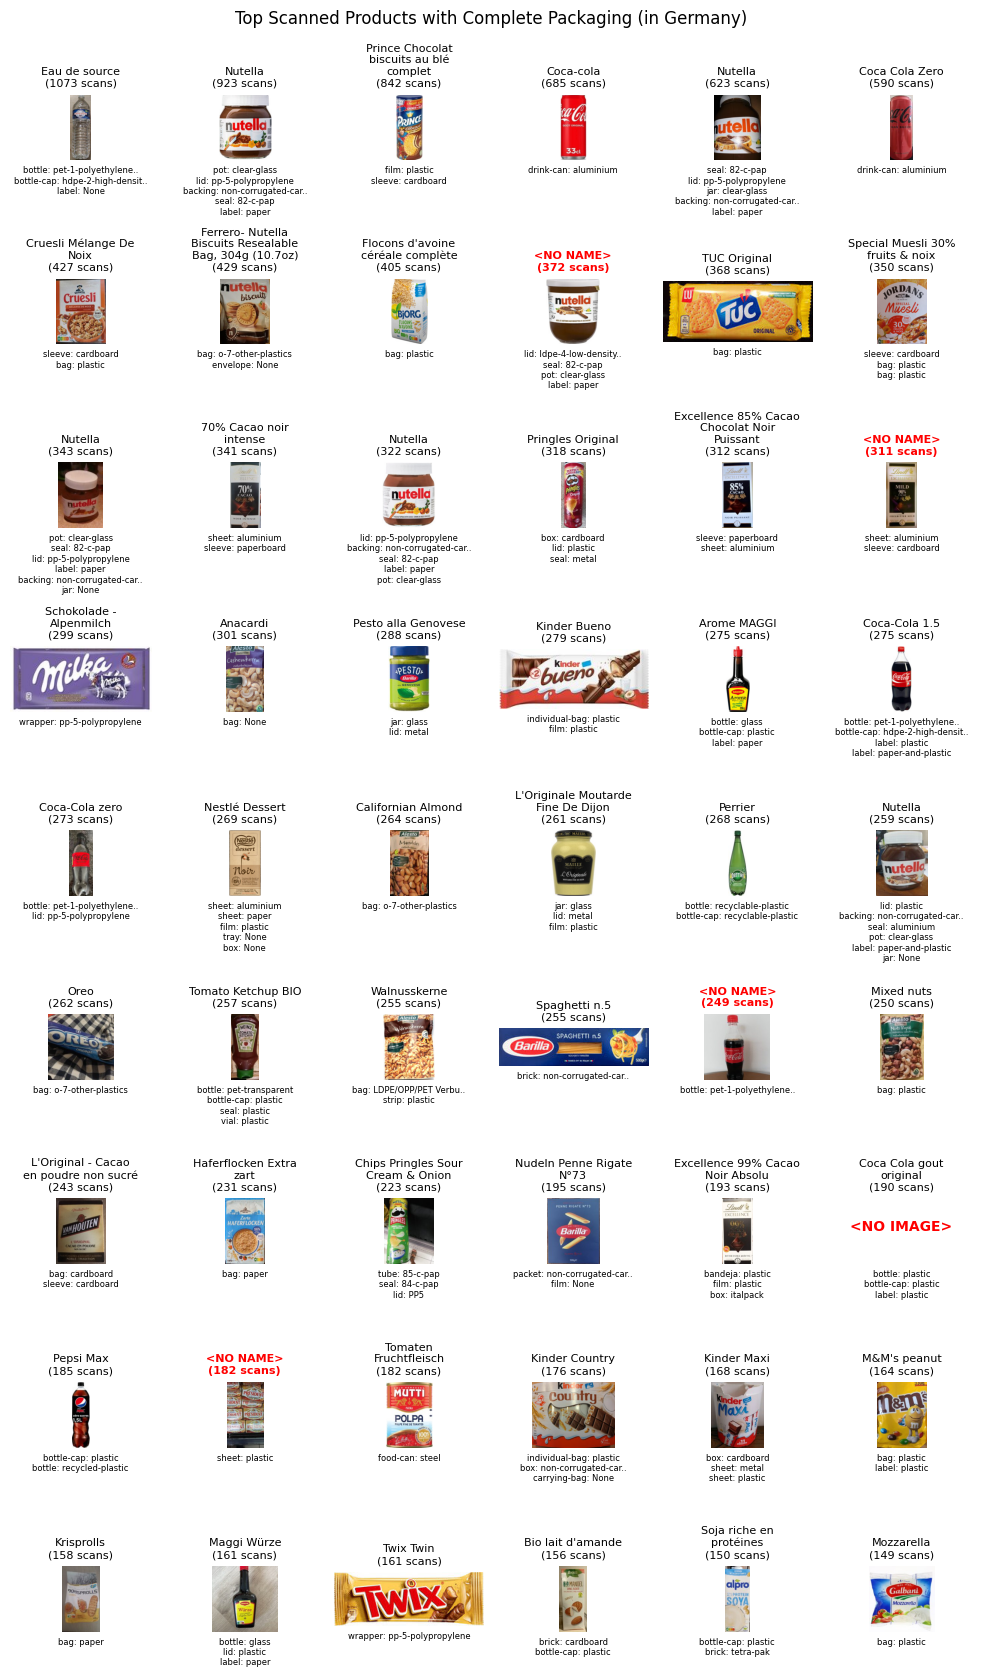

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from textwrap import wrap

n = 54
cols = 6

fig, axs = plt.subplots(math.ceil(n/cols), cols, figsize=(10, 17))

trunc = lambda s, l: s[:l-2] + '..' if len(s) >= l else s

for i, ax in enumerate(axs.flat):

    if i >= n:
        ax.set_axis_off()
        continue
    
    data = prod_df.iloc[i]
    pack = [f"{s[3:]}: {trunc(m[3:], 20) if m else m}" for s, m in zip(data.pack_shapes, data.pack_materials)]

    title = "\n".join(wrap(data.product_name, 20)) if data.product_name else "<NO NAME>"
    title += f"\n({data.unique_scans_n} scans)"
    color = 'black' if data.product_name else 'red'
    fontweight = '500' if data.product_name else '600'
    
    ax.set_title(title, color=color, fontweight=fontweight, size=8)
    
        
    ax.set_xlabel("\n".join(pack), size=6)

    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # show image if product has image url
    if type(data.image_small_url) == str:
        # load image
        with urlopen(data.image_small_url) as response:
            im = PIL.Image.open(response)
            im = np.array(im)
            ax.imshow(im)
    else:
        ax.text(0.5, 0.5, "<NO IMAGE>", horizontalalignment='center', color='red', fontweight='bold')

fig.tight_layout()
fig.subplots_adjust(top=0.93)
fig.suptitle("Top Scanned Products with Complete Packaging (in Germany)");

plt.savefig("off_top_products_germany.png")

## Basic Statistics

### Frequency of products that have 1..n packaging items

<div class="alert alert-block alert-danger">
  <b>Some products have no packaging information - This should not be the case with status "packagings_complete".</b>
</div>

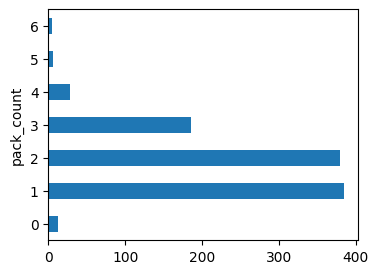

In [5]:
prod_df.pack_count.value_counts().sort_index().plot.barh(figsize=(4,3));

### Show items without packaging information

In [6]:
prod_df[lambda df: df.pack_count == 0]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
8710912064749,Valess,https://images.openfoodfacts.org/images/produc...,[],Vegetarische Schnitzel,19,0,[],[]
4061458007115,"Knusperone, H. & J. Brüggen, Aldi",https://images.openfoodfacts.org/images/produc...,[],Premium-Müsli - Früchte & Nüsse,23,0,[],[]
20793739,Natur Gut Penny,https://images.openfoodfacts.org/images/produc...,[],Bio fettarme H-Milch,8,0,[],[]
4260188785588,mymuesli,https://images.openfoodfacts.org/images/produc...,[],Blueberry,6,0,[],[]
7622210678041,Mondelez,https://images.openfoodfacts.org/images/produc...,[],Daim XXL,5,0,[],[]
4063367226069,K-Classic,https://images.openfoodfacts.org/images/produc...,[],Delikatess Feine Teewurst,5,0,[],[]
8600939212295,Stark,https://images.openfoodfacts.org/images/produc...,[],Prima peanuts,4,0,[],[]
3250392949228,Saint eloi,https://images.openfoodfacts.org/images/produc...,[],Mais BIO 285g,4,0,[],[]
5059319007649,"Kellogg's, Kellogg's - KELLOG Company",https://images.openfoodfacts.org/images/produc...,[],Miel pops loops,4,0,[],[]


### Product without product name

<div class="alert alert-block alert-danger">
  <b>Some products have no product name - This is surprising when status is "packagings_complete".</b>
</div>

In [7]:
missing_name = prod_df.product_name == ""
prod_df[missing_name]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
80135463,Ferrero,https://images.openfoodfacts.org/images/produc...,[{'material': 'en:ldpe-4-low-density-polyethyl...,,372,4,"[en:lid, en:seal, en:pot, en:label]","[en:ldpe-4-low-density-polyethylene, xx:82-c-p..."
3046920029759,Lindt,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:aluminium', 'number_of_units...",,311,2,"[en:sheet, en:sleeve]","[en:aluminium, en:cardboard]"
54491472,Coca-Cola,https://images.openfoodfacts.org/images/produc...,[{'material': 'en:pet-1-polyethylene-terephtha...,,249,1,[en:bottle],[en:pet-1-polyethylene-terephthalate]
3155251205500,President,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",,182,1,[en:sheet],[en:plastic]
7311070346916,Pagen,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene', 'number...",,65,1,[en:bag],[en:pp-5-polypropylene]
20575342,Milbona,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",,28,2,"[en:tray, en:seal]","[en:plastic, en:plastic]"
5413548280189,"Kinder,Ferrero",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene', 'number...",,27,2,"[en:envelope, en:bag]","[en:pp-5-polypropylene, en:pp-5-polypropylene]"
4000607852008,Schogetten,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:cardboard', 'number_of_units...",,24,3,"[en:sleeve, en:tray, en:sheet]","[en:cardboard, en:cardboard, en:aluminium]"
4046434029305,Essreif,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:paper', 'number_of_units': 1...",,28,1,[en:Sticker],[en:paper]


### Items with incomplete "shape" data

<div class="alert alert-block alert-danger">
  <b>Some products are missing packaging "shape" data. This should not be the case with status "packagings_complete".</b>
</div>

In [8]:
is_missing = lambda x: len(x) == 0 or None in x

missing_shapes = prod_df.pack_shapes.map(is_missing)
missing_shapes.map(lambda x: 'missing shape' if x else 'has shape').value_counts()

pack_shapes
has shape        937
missing shape     63
Name: count, dtype: int64

In [9]:
prod_df[missing_shapes]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
4008400401829,Ferrero,https://images.openfoodfacts.org/images/produc...,"[{'material': 'xx:82-c-pap'}, {'material': 'en...",Nutella,126,5,"[None, en:lid, en:seal, en:pot, None]","[xx:82-c-pap, en:pp-5-polypropylene, en:alumin..."
5010029201246,Alpen,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic'}, {'material': 'en:...",Müsli No Added Sugar Swiss Style Muesli,76,3,"[None, en:box, en:bag]","[en:plastic, en:cardboard, en:plastic]"
4011100001305,Mars,https://images.openfoodfacts.org/images/produc...,[{'material': 'en:plastic'}],M&M's,48,1,[None],[en:plastic]
20006105,Tastino,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene'}, {'mate...",Pan de centeno integral,33,2,"[None, en:fastener]","[en:pp-5-polypropylene, en:plastic]"
4056489232872,Belbake,https://images.openfoodfacts.org/images/produc...,[{'recycling': 'en:recycle'}],Cocoa powder,32,1,[None],[None]
...,...,...,...,...,...,...,...,...
4260462119887,Cay-Consulting GmbH & Co. KG,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:glass-aluminium', 'number_of...",Cay Gourmet Crunchy Haselnuss,3,2,"[None, en:label]","[en:glass-aluminium, en:plastic]"
4008366010004,FROSTA,https://images.openfoodfacts.org/images/produc...,[],Tortellini Rahmspinat,2,0,[],[]
4316268588843,BioBio,https://images.openfoodfacts.org/images/produc...,[{'material': 'en:plastic'}],Krusten Brötchen,2,1,[None],[en:plastic]


### Items with incomplete "materials" data

<div class="alert alert-block alert-danger">
  <b>Some products are missing packaging "material" data. This should not be the case with status "packagings_complete".</b>
</div>

In [10]:
missing_materials = prod_df.pack_materials.map(is_missing)
missing_materials.map(lambda x: 'missing material' if x else 'has material').value_counts()

pack_materials
has material        931
missing material     69
Name: count, dtype: int64

In [11]:
prod_df[missing_materials]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
3274080005003,Cristaline,https://images.openfoodfacts.org/images/produc...,[{'material': 'en:pet-1-polyethylene-terephtha...,Eau de source,1073,3,"[en:bottle, en:bottle-cap, en:label]","[en:pet-1-polyethylene-terephthalate, en:hdpe-..."
8000500310427,"Nutella,Ferrero",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:o-7-other-plastics', 'number...","Ferrero- Nutella Biscuits Resealable Bag, 304g...",429,2,"[en:bag, en:envelope]","[en:o-7-other-plastics, None]"
3017620429484,"Ferrero,Nutella",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:clear-glass', 'number_of_uni...",Nutella,343,6,"[en:pot, en:seal, en:lid, en:label, en:backing...","[en:clear-glass, xx:82-c-pap, en:pp-5-polyprop..."
20267605,"Alesto Selection,Lidl",https://images.openfoodfacts.org/images/produc...,"[{'number_of_units': 1, 'quantity_per_unit': '...",Anacardi,301,1,[en:bag],[None]
7613035040823,"Nestlé,Nestlé Dessert",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:aluminium', 'number_of_units...",Nestlé Dessert,269,5,"[en:sheet, en:sheet, en:film, en:tray, en:box]","[en:aluminium, en:paper, en:plastic, None, None]"
...,...,...,...,...,...,...,...,...
4006040422013,Rapunzel,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:non-corrugated-cardboard', '...",Rice Choco vegane helle Schokolade,1,2,"[en:brick, en:film]","[en:non-corrugated-cardboard, None]"
4311501648926,Edeka,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",12 Milch BRÖTCHEN,2,2,"[en:bag, en:fastener]","[en:plastic, None]"
5449000138514,Coca-Cola,https://images.openfoodfacts.org/images/produc...,[],Coca-Cola zero,3,0,[],[]


## Labels of Packaging Shapes

In [12]:
packagingShapes = [s for shapes in prod_df.pack_shapes for s in shapes]
packagingShapesEn = [s for s in packagingShapes if s and s.startswith('en:')]
packagingShapesNonEn = [s for s in packagingShapes if s and not s.startswith('en:')]

### Most Frequent English Shape Labels

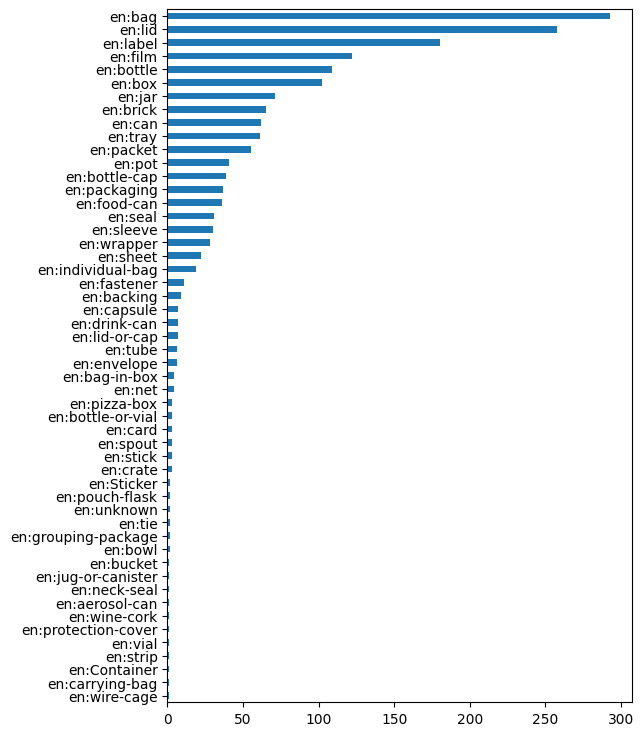

In [13]:
pd.Series(packagingShapesEn).value_counts(ascending=True).plot.barh(figsize=(6, 9));

### Most Frequent Non-English Shape Labels

<div class="alert alert-block alert-danger">
  <b>All products should use the standard english taxonomy names if status is "packagings_complete".</b>
</div>

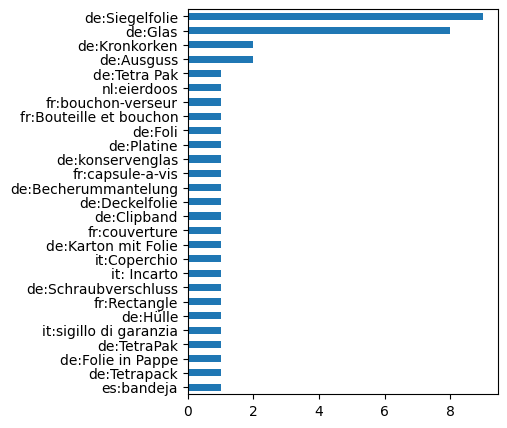

In [14]:
pd.Series(packagingShapesNonEn).value_counts(ascending=True).plot.barh(figsize=(4, 5));

### Investigate products with specific package shape labels

- pizza-box
- brick
- Siegelfolie (German)

In [15]:
search = 'en:pizza-box'
prod_df[lambda df: df.pack_shapes.map(lambda shapes: search in shapes)]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
4001724039297,Dr. Oetker Ristorante,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:cardboard', 'number_of_units...",Pizza Salame Mozzarella Pesto,7,2,"[en:pizza-box, en:bag]","[en:cardboard, en:plastic]"
4009233014002,"Wagner,Original Wagner,Fertigessen",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:non-corrugated-cardboard', '...",Piccolinis Salami,8,1,[en:pizza-box],[en:non-corrugated-cardboard]
4250073457669,Followfood,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",Pizza Funghi mit Bio Dinkelboden,4,2,"[en:wrapper, en:pizza-box]","[en:plastic, en:paper]"


In [16]:
search = 'en:brick'
prod_df[lambda df: df.pack_shapes.map(lambda shapes: search in shapes)]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
8076800195057,Barilla,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:non-corrugated-cardboard', '...",Spaghetti n.5,255,1,[en:brick],[en:non-corrugated-cardboard]
4056489346357,"Vemondo, Lidl",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:cardboard', 'number_of_units...",Bio lait d'amande,156,2,"[en:brick, en:bottle-cap]","[en:cardboard, en:plastic]"
5411188115472,Alpro,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'shape': 'en:bottl...",Soja riche en protéines,150,2,"[en:bottle-cap, en:brick]","[en:plastic, en:tetra-pak]"
4056489244691,"Vemondo, Lidl, Grønvang Food",https://images.openfoodfacts.org/images/produc...,[{'material': 'en:hdpe-2-high-density-polyethy...,Bio Hafer ohne Zuckerzusatz,126,3,"[en:lid, en:brick, de:Siegelfolie]","[en:hdpe-2-high-density-polyethylene, xx:84-c-..."
40264769,"Deli Reform, Walter Rau Lebensmittelwerke",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene', 'number...",Deli Reform - Das Original,101,4,"[en:lid, en:label, en:brick, de:Siegelfolie]","[en:pp-5-polypropylene, en:paper, en:pp-5-poly..."
...,...,...,...,...,...,...,...,...
4006040422013,Rapunzel,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:non-corrugated-cardboard', '...",Rice Choco vegane helle Schokolade,1,2,"[en:brick, en:film]","[en:non-corrugated-cardboard, None]"
5411188511328,Alpro,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:tetra-pak', 'number_of_units...",Single Soya cream,1,2,"[en:brick, en:lid-or-cap]","[en:tetra-pak, en:plastic]"
7610200391186,"Valflora, Migros",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:tetra-pak', 'number_of_units...",Demi-crème,1,1,[en:brick],[en:tetra-pak]


In [17]:
search = 'de:Siegelfolie'
prod_df[lambda df: df.pack_shapes.map(lambda shapes: search in shapes)]

,brands,image_small_url,packagings,product_name,unique_scans_n,pack_count,pack_shapes,pack_materials
code,,,,,,,,
4056489244691,"Vemondo, Lidl, Grønvang Food",https://images.openfoodfacts.org/images/produc...,[{'material': 'en:hdpe-2-high-density-polyethy...,Bio Hafer ohne Zuckerzusatz,126,3,"[en:lid, en:brick, de:Siegelfolie]","[en:hdpe-2-high-density-polyethylene, xx:84-c-..."
40264769,"Deli Reform, Walter Rau Lebensmittelwerke",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene', 'number...",Deli Reform - Das Original,101,4,"[en:lid, en:label, en:brick, de:Siegelfolie]","[en:pp-5-polypropylene, en:paper, en:pp-5-poly..."
20810405,"Chef select, Lidl, Heinrich Kühlmann",https://images.openfoodfacts.org/images/produc...,[{'material': 'en:pet-1-polyethylene-terephtha...,Hummus Pikant mit Chili verfeinert,39,3,"[en:tray, en:lid, de:Siegelfolie]","[en:pet-1-polyethylene-terephthalate, en:pet-1..."
20521493,Vitasia,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:clear-glass', 'number_of_uni...",Soja Soße,36,6,"[en:bottle, en:lid, de:Siegelfolie, en:label, ...","[en:clear-glass, en:pp-5-polypropylene, en:pla..."
8715700209159,Heinz,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pet-transparent', 'number_of...",Mayonnaise Das Original,26,4,"[en:bottle, en:lid, de:Siegelfolie, en:label]","[en:pet-transparent, en:pp-5-polypropylene, No..."
4061458135115,"Wonnemeyer, ALDI, Heinrich Kühlmann",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pet-transparent', 'number_of...",Hummus - Ras El Hanout,25,4,"[en:tray, en:lid, de:Siegelfolie, en:label]","[en:pet-transparent, en:pet-transparent, en:pl..."
8719200237025,"Lätta,Upfield, Lätta, Lätta",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:plastic', 'number_of_units':...",Lätta,18,3,"[en:tray, en:lid, de:Siegelfolie]","[en:plastic, en:plastic, en:aluminium]"
8690804682902,"Suntat, BLG Kardesler",https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:clear-glass', 'number_of_uni...",Tahin Sesampaste,9,4,"[en:jar, en:lid, de:Siegelfolie, en:label]","[en:clear-glass, en:plastic-tinplate, en:plast..."
4002674044959,Ostmann,https://images.openfoodfacts.org/images/produc...,"[{'material': 'en:pp-5-polypropylene', 'number...",Rosmarin gemahlen,3,4,"[en:can, en:lid, en:label, de:Siegelfolie]","[en:pp-5-polypropylene, en:plastic, en:plastic..."


### Product packagings example

In [18]:
prod_df.iloc[59].packagings

[{'material': 'fr:Carton + plastique PE',
  'number_of_units': 1,
  'quantity_per_unit': '406 g',
  'quantity_per_unit_unit': 'g',
  'quantity_per_unit_value': '406',
  'recycling': 'en:recycle',
  'shape': 'en:pot',
  'weight_measured': 14.85},
 {'material': 'fr:Carton + plastique Pe',
  'number_of_units': 1,
  'quantity_per_unit': '406 g',
  'quantity_per_unit_unit': 'g',
  'quantity_per_unit_value': '406',
  'recycling': 'en:recycle',
  'shape': 'en:lid',
  'weight_measured': 6.65},
 {'material': 'fr:Plastique pp',
  'number_of_units': '1',
  'quantity_per_unit': '406 g',
  'quantity_per_unit_unit': 'g',
  'quantity_per_unit_value': '406',
  'recycling': 'en:recycle',
  'shape': 'en:film'}]

## Labels of Packaging Material

In [19]:
packagingMaterials = [s for mat in prod_df.pack_materials for s in mat]
packagingMaterialsEn = [s for s in packagingMaterials if s and s.startswith('en:')]
packagingMaterialsNonEn = [s for s in packagingMaterials if s and not s.startswith('en:')]

### Most Frequent English Material Labels

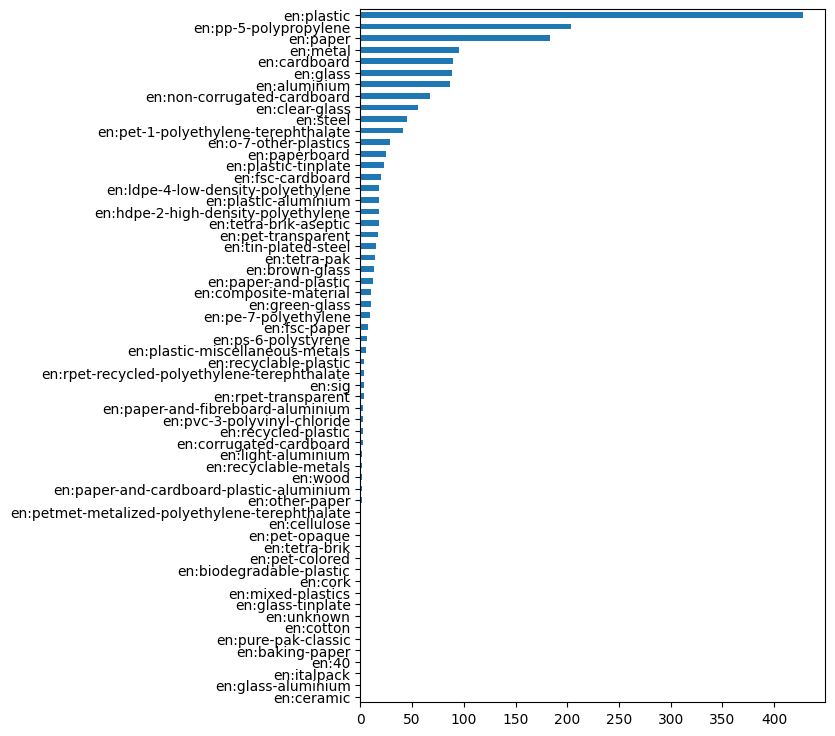

In [20]:
pd.Series(packagingMaterialsEn).value_counts(ascending=True).plot.barh(figsize=(6, 9));

### Most Frequent Non-English Material Labels

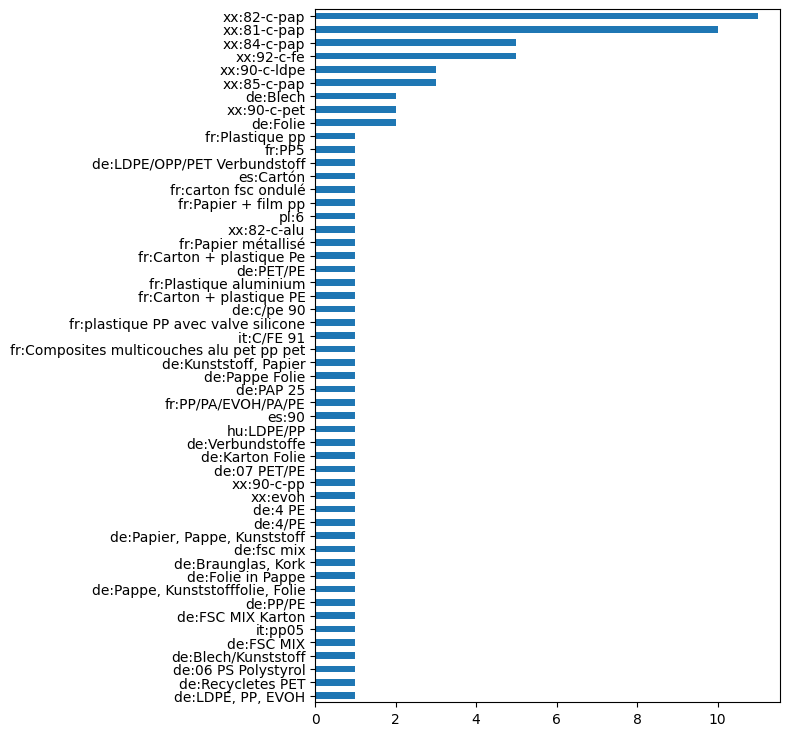

In [21]:
pd.Series(packagingMaterialsNonEn).value_counts(ascending=True).plot.barh(figsize=(6, 9));